# 1D Convolution for Time Series Forecasting

In this notebook, we will explore how to use **1D Convolutional Neural Networks (1D CNNs)** to model and forecast time series data.

### Why 1D Convolution?

While CNNs are traditionally used for image data, they are also effective for **time series**, where the data is one-dimensional but has local temporal patterns. A 1D convolution slides a kernel across the time axis to detect **temporal features**.

### Applications

1D CNNs have been successfully applied to:
- Stock price prediction
- Weather and climate forecasting
- Physiological signals (e.g., ECG, EEG)
- Industrial sensor data
- Seismic or gravitational wave time series
- ...


### Objective

We aim to:
- Use **1D Conv layers** to extract features from a sliding window of past values
- Predict **future values** of the time series


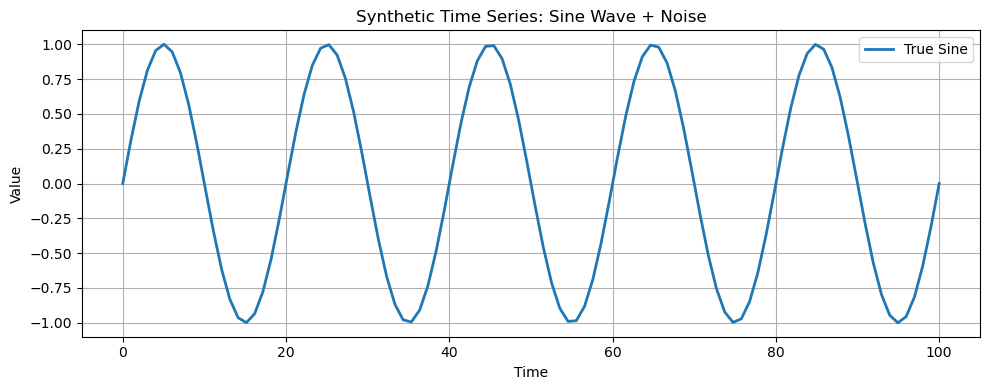

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
n_samples = 100             # Total number of time points
freq = 0.05                 # Frequency of sine wave

# Generate time and signal
t = np.linspace(0, 100, n_samples)
signal = np.sin(2 * np.pi * freq * t) # Sine wave

# Plot
plt.figure(figsize=(10, 4))
plt.plot(t, signal, label="True Sine", lw=2)
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Synthetic Time Series: Sine Wave + Noise")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 1D CNN Time Series Forecaster (Forecast Last Sample)

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------------------------------
# 1. Generate clean sine wave time series
# -----------------------------------------------------
n_samples = 1000
freq = 0.05
t = np.linspace(0, 100, n_samples)
signal = np.sin(2 * np.pi * freq * t)  # Clean sine wave


# -----------------------------------------------------
# Adding Gaussian Noise
# Uncomment if you want noisy training dataset
# -----------------------------------------------------
#noise_std = 0.2
#noise = np.random.normal(0, noise_std, n_samples)
#data = signal + noise

# -----------------------------------------------------
# 2. Create sliding windows for forecasting
# -----------------------------------------------------
window_size = 30
X = []
y = []

for i in range(len(signal) - window_size):
    X.append(signal[i:i+window_size])       # Input: past 30 values, #TODO: replace 'signal' with 'data' if you want noisy training data
    y.append(signal[i+window_size])         # Output: next value

X = np.array(X)  # Shape: [N, window_size]
y = np.array(y)  # Shape: [N]

# Add channel dim for Conv1D: [B, 1, T]
X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(1)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

# -----------------------------------------------------
# 3. Time-respecting train/test split
# -----------------------------------------------------
split_idx = int(0.8 * len(X_tensor))
X_train, X_test = X_tensor[:split_idx], X_tensor[split_idx:]
y_train, y_test = y_tensor[:split_idx], y_tensor[split_idx:]

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=64, shuffle=False)

# -----------------------------------------------------
# 4. Define the 1D CNN model
# -----------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = nn.Sequential(
    nn.Conv1d(1, 16, kernel_size=3, padding=1),   # → [B, 16, 30]
    nn.LeakyReLU(0.01),
    nn.Conv1d(16, 32, kernel_size=3, padding=1),  # → [B, 32, 30]
    nn.LeakyReLU(0.01),
    nn.Flatten(),                                 # → [B, 32*30]
    nn.Linear(32 * window_size, 1)                # → [B, 1]
).to(device)

# -----------------------------------------------------
# 5. Train the model
# -----------------------------------------------------
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

epochs = 20
train_losses = []

for epoch in range(epochs):
    model.train()
    total_loss = 0.0

    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        preds = model(batch_x)
        loss = criterion(preds, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)

    print(f"Epoch {epoch+1:2d} | Train Loss: {avg_loss:.6f}")

Using device: cuda
Epoch  1 | Train Loss: 0.345771
Epoch  2 | Train Loss: 0.157957
Epoch  3 | Train Loss: 0.039849
Epoch  4 | Train Loss: 0.006095
Epoch  5 | Train Loss: 0.001780
Epoch  6 | Train Loss: 0.000495
Epoch  7 | Train Loss: 0.000322
Epoch  8 | Train Loss: 0.000246
Epoch  9 | Train Loss: 0.000211
Epoch 10 | Train Loss: 0.000185
Epoch 11 | Train Loss: 0.000163
Epoch 12 | Train Loss: 0.000145
Epoch 13 | Train Loss: 0.000129
Epoch 14 | Train Loss: 0.000116
Epoch 15 | Train Loss: 0.000104
Epoch 16 | Train Loss: 0.000095
Epoch 17 | Train Loss: 0.000087
Epoch 18 | Train Loss: 0.000080
Epoch 19 | Train Loss: 0.000074
Epoch 20 | Train Loss: 0.000069


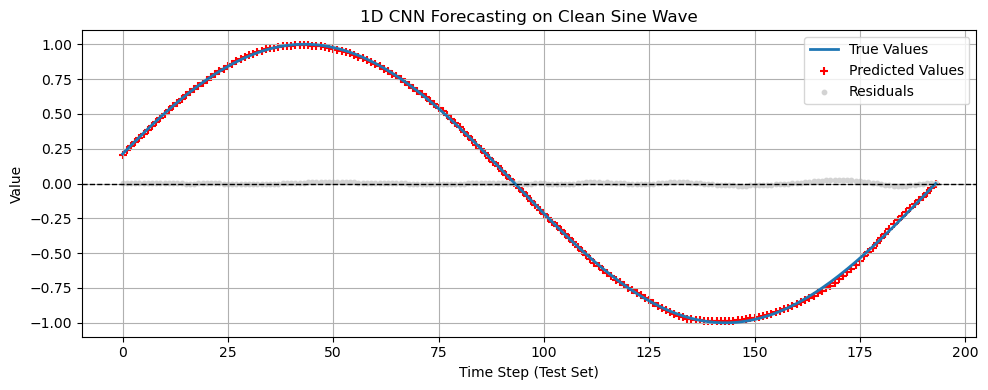

In [32]:
# -----------------------------------------------------
# 6. Evaluate and plot predictions vs. ground truth
# -----------------------------------------------------
model.eval()
preds = []
targets = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.to(device)
        output = model(batch_x)
        preds.append(output.cpu())
        targets.append(batch_y)

preds = torch.cat(preds).squeeze().numpy()
targets = torch.cat(targets).squeeze().numpy()
residuals = targets - preds  # Difference between true and predicted

plt.figure(figsize=(10, 4))
plt.plot(targets, label="True Values", linewidth=2)
plt.scatter(np.arange(preds.shape[0]), preds, label="Predicted Values", marker='+', c='red')
plt.scatter(range(len(residuals)), residuals, color='lightgray', s=10, label="Residuals")
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title("1D CNN Forecasting on Clean Sine Wave")
plt.xlabel("Time Step (Test Set)")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Applications of 1D CNNs in Particle and Astroparticle Physics

1D Convolutional Neural Networks (1D CNNs) are powerful tools for analyzing sequential data such as time series. In physics, they are increasingly used for:

- **Signal classification** from particle detectors
- **Astrophysical waveform analysis**, such as in gravitational wave astronomy
- **Sensor-based anomaly detection** in experimental facilities
- **Trigger and event filtering** in high-energy physics


## Case Study: G2Net Gravitational Wave Detection

A notable example of 1D CNNs in action is the **[G2Net Gravitational Wave Detection](https://www.kaggle.com/competitions/g2net-gravitational-wave-detection/overview)** Kaggle competition.

-  **Goal**: Build a model to detect real gravitational wave signals (binary black hole mergers) embedded in detector noise.
- **Input**: Time series from LIGO interferometers
- **Task**: **Binary classification** — does the signal contain a gravitational wave (`1`) or not (`0`)?


## Winning Approach

The top solutions used **deep 1D CNN architectures** to process raw time series directly:

- Learned time-domain features without requiring spectrogram conversion
- Demonstrated strong performance by leveraging **efficient convolutional blocks**, **batch normalization**, and **augmentation strategies**

> 🔗 Competition page: [https://www.kaggle.com/competitions/g2net-gravitational-wave-detection/overview](https://www.kaggle.com/competitions/g2net-gravitational-wave-detection/overview)

This competition showcases how **1D CNNs can be highly effective** in scientific classification problems involving structured signals — such as those from gravitational wave detectors, neutrino observatories, or high-energy particle experiments.
